# Data mount from gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Install relevant libraries

In [2]:
%%capture
pip install transformers

# Install external packages and modules

In [3]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import SGD
from transformers import AutoModelForTokenClassification, AutoTokenizer


# Load CSV Data

In [53]:
path = '/content/drive/MyDrive/Hisab/datasets/Hisab_Ner_Low_Label.csv'
df = pd.read_csv(path)
df

,text,labels
0,অগ্রণী ব্যাংকের জ্যেষ্ঠ কর্মকর্তা পদে নিয়োগ প...,ORG ORG O O O O O O O O O O
1,ব্যাংকের চেয়ারম্যানও এ অভিযোগের সত্যতা স্বীকা...,O O O O O O O O
2,আজ শুক্রবার বিকেল চারটা থেকে পাঁচটা পর্যন্ত এক...,O O O O O O O O O O O O O O
3,এ ছাড়া কয়েকটি পরীক্ষাকেন্দ্রে ছাত্রলীগের নেত...,O O O O ORG O O O O O O O O O O O
4,ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ই...,O O O ORG ORG ORG ORG ORG B-PERSON I-PERSON I-...
...,...,...
3462,গাজীপুরের নতুন বাজার এলাকায় গতকাল দুপুরে মেঘন...,GPE GPE GPE O O O ORG ORG ORG ORG ORG ORG O O ...
3463,গন্তব্যস্থলের ঠিকানা লেখা ছিল হেল অ্যান্ড হার্...,O O O O O ORG ORG ORG ORG ORG GPE O O
3464,কুমিল্লা বিশ্ববিদ্যালয়ের জন্য একটি বাস উপহার ...,GPE GPE O O O O O ORG ORG ORG O
3465,"বিশ্ববিদ্যালয়ের পরিবহন শাখা সূত্রে জানা গেছে,...",O O O O O O O O O ORG ORG ORG O O O O O GPE O ...


# Initialize Tokenizer











In [ ]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')


In [8]:
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/mbert-bengali-ner")


# Create Dataset Class

In [9]:
label_all_tokens = False

def align_label(texts, labels):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

class DataSequence(torch.utils.data.Dataset):

    def __init__(self, df):

        lb = [i.split() for i in df['labels'].values.tolist()]
        txt = df['text'].values.tolist()
        self.texts = [tokenizer(str(i),
                               padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for i in txt]
        self.labels = [align_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels

In [ ]:
len(df)

# Split Data and Define Unique Labels

In [54]:
# df = df[1000:1100]

labels = [i.split() for i in df['labels'].values.tolist()]
unique_labels = set()

for lb in labels:
        [unique_labels.add(i) for i in lb if i not in unique_labels]
labels_to_ids = {k: v for v, k in enumerate(unique_labels)}
ids_to_labels = {v: k for v, k in enumerate(unique_labels)}

df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                            [int(.8 * len(df)), int(.9 * len(df))])

In [55]:
ids_to_labels

{0: 'ORG',
 1: 'LAW',
 2: 'GPE',
 3: 'U-PERSON',
 4: 'O',
 5: 'I-PERSON',
 6: 'B-PERSON'}

In [ ]:
unique_labels

{'B-PERSON', 'GPE', 'I-PERSON', 'LAW', 'O', 'ORG', 'U-PERSON'}

# Build Model

In [56]:
class HisabNerBertModel(torch.nn.Module):
    """This class build a model model using hagging face
    pretrain model called 'sagorsarker/mbert-bengali-ner' which was
    deployed by sagorsarkar. trained the bert model using
    Bengali text with 7 different labels.
    """

    def __init__(self):

        super(HisabNerBertModel, self).__init__()
        self.hisabNerBanglaBert = AutoModelForTokenClassification.from_pretrained(
            "sagorsarker/mbert-bengali-ner", num_labels=7)

    def forward(self, input_id, mask, label):
        output = self.hisabNerBanglaBert(
            input_ids=input_id, attention_mask=mask, labels=label,
            return_dict=False)

        return output

# Model Training

In [57]:

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []

In [58]:
def train_loop(model, df_train, df_val):

    train_dataset = DataSequence(df_train)
    val_dataset = DataSequence(df_val)

    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    if use_cuda:
        model = model.cuda()

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(EPOCHS):


        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][train_label[i] != -100]
              label_clean = train_label[i][train_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_train += acc
              total_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, val_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][val_label[i] != -100]
              label_clean = val_label[i][val_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_val += acc
              total_loss_val += loss.item()

        val_accuracy = total_acc_val / len(df_val)

        val_loss = total_loss_val / len(df_val)

        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train): .3f} | Accuracy: {total_acc_train / len(df_train): .3f} | Val_Loss: {total_loss_val / len(df_val): .3f} | Accuracy: {total_acc_val / len(df_val): .3f}')

        training_accuracy.append(total_loss_train / len(df_train))
        training_loss.append((total_acc_train / len(df_train)).item())
        validation_accuracy.append(val_accuracy.item())
        validation_loss.append(val_loss)


    torch.save(model, '/content/drive/MyDrive/Hisab/hisab_ner.pth')

LEARNING_RATE = 5e-3
EPOCHS = 2
BATCH_SIZE = 2

model = HisabNerBertModel()
train_loop(model, df_train, df_val)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1387/1387 [04:13<00:00,  5.48it/s]


Epochs: 1 | Loss:  0.490 | Accuracy:  0.869 | Val_Loss:  0.376 | Accuracy:  0.870


100%|██████████| 1387/1387 [04:27<00:00,  5.18it/s]


Epochs: 2 | Loss:  0.315 | Accuracy:  0.893 | Val_Loss:  0.318 | Accuracy:  0.891


In [31]:
from matplotlib import pyplot as plt

In [32]:
validation_accuracy

[0.9208362698554993, 0.9208362698554993]

<function matplotlib.pyplot.show(close=None, block=None)>

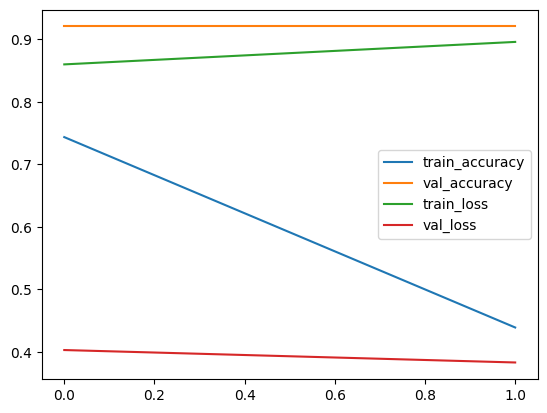

In [33]:
plt.plot(training_accuracy, label='train_accuracy')
plt.plot(validation_accuracy,label='val_accuracy')
plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')

plt.legend()
plt.savefig('hisab_ner.png')
plt.show

# Evaluate Model

In [34]:
def evaluate(model, df_test):

    test_dataset = DataSequence(df_test)

    test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0.0

    for test_data, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_data['attention_mask'].squeeze(1).to(device)

            input_id = test_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, test_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][test_label[i] != -100]
              label_clean = test_label[i][test_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_test += acc

    val_accuracy = total_acc_test / len(df_test)
    print(f'Test Accuracy: {total_acc_test / len(df_test): .3f}')


evaluate(model, df_test)

Test Accuracy:  0.936


# Predict One Sentence

In [59]:
def align_word_ids(texts):

    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids


def predict(model, sentence):


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # if use_cuda:
    #     model = model.cuda()

    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]
    sentence = sentence.split(' ')
    ner_result = ''
    if len(sentence)==len(prediction_label):
        for idx in range(len(prediction_label)):
            # if prediction_label[idx] == 'U-PERSON':
            #     ner_result += sentence[idx] + ','
            if prediction_label[idx] == 'B-PERSON':
                ner_result += sentence[idx]
            elif prediction_label[idx] == 'I-PERSON':
                ner_result += ' ' + sentence[idx]
        print(ner_result+'\n')
    else:
        print('------------------------------------------------------------------------\n\nInput Text: {}'.format(sentence))
        print('Predicted labels: {}\n'.format(prediction_label))



# Infer on example sentence

In [60]:
sentence = 'আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম'

# Inference Result

In [61]:
model = torch.load('/content/drive/MyDrive/Hisab/hisab_ner.pth')

# predict(model, sentence)

In [62]:
predict(model, sentence)

আব্দুর রহিম

